<h1>test on 368 datapoints noise </h1>

In [1]:
import rdkit
import deepchem as dc
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
import time
from deepchem.metrics import to_one_hot
from deepchem.feat.mol_graphs import ConvMol
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate
from tensorflow.keras import initializers
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

# Optimizer
optimizer = tf.keras.optimizers.Adam(0.001)

#K-fold
k_fold = 4
k = k_fold
max_epoch = 100
# optimizer = tf.keras.optimizers.Adagrad(0.003)

2022-04-09 21:26:37.394138: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-09 21:26:37.394169: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
rdkit.__version__

'2021.09.3'

In [3]:
dc.__version__

'2.6.1'

In [4]:
np.__version__

'1.21.4'

In [5]:
tf.__version__

'2.8.0'

In [6]:
# Loading molecular data
df = pd.read_csv('molecule_parameters.csv')
df.dropna(how='any', inplace=True)

In [7]:
# DDG Standard deviation
np.std(df.ddg)

2.697637870606162

In [8]:
df['entropy'][0]

'-34.07407324'

# Adding Noise using Gaussian

In [9]:
#Normalizing entropy and add some noise
df['entropy'] = df['entropy'].astype(float) + np.random.normal(np.sqrt(df['entropy'].astype(float).mean()), 1, len(df))

In [10]:
df['entropy'][0]

-30.728364274673314

# Reading PDB files

In [12]:
# # start time
# start = time.time()
# # Dictionary with complex names as keys and molecule as values
# PDBs = {}
# from os import listdir
# from os.path import isfile, join
# # mypath = '../../../../../../Documents/GitHub/Binding-Free-Energy-Prediction-Host-Guest-System/pdbbind/raw-data/'
# mypath = 'dataset234/'
# onlyfiles = [f for f in listdir(mypath) if f not in ('.DS_Store') and f in (df['complex-name'].tolist())]
# for f in onlyfiles:
#     print(f)
#     PDBs.update({f: rdkit.Chem.rdmolfiles.MolFromPDBFile(mypath + f + '/com_new.pqr')})

# for key, value in dict(PDBs).items():
#     if value is None:
#         del PDBs[key]
# time.sleep(1)
# # end time
# end = time.time()
# # total time taken
# print(f"PDB file reading runtime is {(end - start)/60} minutes")

In [64]:
# ## Save PDB
# import pickle
# with open('PDBs-368.pkl', 'wb') as file:
#     pickle.dump(PDBs, file)

In [11]:
## Load PDB
import pickle
PDBs= {}
with open('PDBs-368.pkl', 'rb') as file:
    PDBs = pickle.load(file)

In [12]:
# Randomly shuffling the PDBs
import random
l = list(PDBs.items())
random.shuffle(l)
PDBs = dict(l)

<AxesSubplot:ylabel='Frequency'>

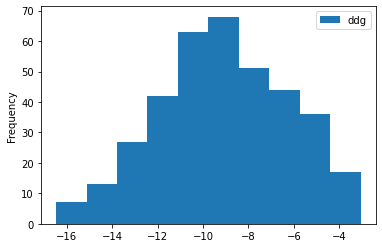

In [13]:
# DDG distribution for dataset of ~500 datapoints
PDB_names = list(PDBs.keys())
df_500= pd.DataFrame()
ddg_list= []
for i in PDB_names:
    ddg_list.append(float(df[df['complex-name']==i]['ddg']))
df_500 = pd.DataFrame({'ddg': ddg_list}) 

import matplotlib.pyplot as plt
# plt.xlabel('ddg')
df_500.plot.hist('ddg')

# Models

<h3>PGNNS model </h3>

In [14]:
## !!!!!!!! important
## !!!!!!!! important
## !!!!!!!! important
## !!!!!!!! important
# batch_size = int(len(pdb_names_train)/4)
# batch_size
# batch_size=10

In [15]:
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate
from tensorflow.keras import initializers


class PGNNS(tf.keras.Model):

  def modify_graphgather(self, batch_size):
    self.readout.batch_size = batch_size
    self.batch_size = batch_size
  def __init__(self, batch_size):
    super(PGNNS, self).__init__()
    self.input_shapes = None
    self.batch_size = batch_size
    self.gc1 = GraphConv(128, activation_fn=tf.nn.tanh)
    self.batch_norm1 = layers.BatchNormalization()
    self.gp1 = GraphPool()

    self.gc2 = GraphConv(128, activation_fn=tf.nn.tanh)
    self.batch_norm2 = layers.BatchNormalization()
    self.gp2 = GraphPool()

    self.dense1 = layers.Dense(128, activation=tf.nn.tanh)
    self.batch_norm3 = layers.BatchNormalization()
    self.readout = GraphGather(batch_size=self.batch_size, activation_fn=tf.nn.tanh)

    self.dense2 = layers.Dense(1)
    self.dense3 = layers.Dense(1, 
         kernel_initializer=initializers.Constant([0.5, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1]),
         bias_initializer=initializers.Zeros())

  def call(self, inputs):
    inputs = inputs[0]
    x = []
#     input_shapes = [[4822, 75], [11, 2], [4822], [1142, 1], [1635, 2], [2042, 3],
#                    [3, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10]]
    for i in range(len(self.input_shapes)):
        x.append(tf.reshape(inputs[i][inputs[i] != 1.123456], self.input_shapes[i]))
    for i in range(1, len(self.input_shapes)):
        x[i] = tf.cast(x[i], tf.int32)
    x_add = tf.reshape(inputs[13][inputs[13] != 1.123456], [self.batch_size, 16])
    gc1_output = self.gc1(x)
    batch_norm1_output = self.batch_norm1(gc1_output)
    gp1_output = self.gp1([batch_norm1_output] + x[1:])

    gc2_output = self.gc2([gp1_output] + x[1:])
    batch_norm2_output = self.batch_norm1(gc2_output)
    gp2_output = self.gp2([batch_norm2_output] + x[1:])

    dense1_output = self.dense1(gp2_output)
    batch_norm3_output = self.batch_norm3(dense1_output)
    readout_output = self.readout([batch_norm3_output] + x[1:])
    
    model_var = self.dense2(readout_output)
    binding_affinity = tf.concat([model_var, x_add], axis=1)
    return self.dense3(binding_affinity)
# PGNNS = PGNNS(train_split_index)
# PGNNS.compile(loss='mse', optimizer='adam')

In [16]:
k

4

In [17]:
len(PDBs)

368

# K-fold

In [18]:
import warnings
warnings.filterwarnings('ignore')

TRAIN_SET_PERCENTAGE = 1-(1/k)
VAL_SET_PERCENTAGE = 1/k
PDBs.pop('',None)

# PGNNS model variables
PGNNS_train_losses = [[] for _ in range(k_fold)]
PGNNS_val_losses = [[] for _ in range(k_fold)]
PGNNS_rmse_train, PGNNS_rmse_test = [], []

# DDS model variables
DDS_train_losses = [[] for _ in range(k_fold)]
DDS_val_losses = [[] for _ in range(k_fold)]
DDS_rmse_train, DDS_rmse_test = [], []

# Defining Featurizer
featurizer = dc.feat.ConvMolFeaturizer(per_atom_fragmentation=False)

# start time
start = time.time()

X, X_ids = [], []

# Featurize PDB's
for i in PDBs.keys():
    X_ids.append(i)
    X.append(featurizer.featurize(PDBs[i]))
pdb_names = [i.split('-')[0] for i in X_ids] 
X = [x[0] for x in X]
# k-fold loop
for fold in range(k_fold):
    # fold=0 -> 0 * (0.25 * 72) = 0
    # fold=1 -> 1 * (0.25 * 72) = 18
    # fold=2 -> 2 * (0.25 * 72) = 36
    # fold=3 -> 3 * (0.25 *72) = 54
    pdb_names_val, pdb_names_test = [], []
    pdb_names_train, X_val_featurized, X_test_featurized, X_train_featurized  = [], [], [], []
    

     
    TEST_SIZE = int(len(X) * VAL_SET_PERCENTAGE)
    val_split_index_begin = int(fold * TEST_SIZE)
#     print(f"begin {val_split_index_begin}")
    val_split_index_end = int(val_split_index_begin) + int(TEST_SIZE)
#     print(f"end {val_split_index_end}")

    # validation
    pdb_names_val = pdb_names[val_split_index_begin:val_split_index_end]

    # Test set
    pdb_names_test = pdb_names[val_split_index_begin:val_split_index_end]
    
    # Train set
    pdb_names_train = [pdb_names[i] for i in range(len(pdb_names)) if i not in range(val_split_index_begin,val_split_index_end)]

    
    X_val_featurized = X[val_split_index_begin : val_split_index_end]
    X_test_featurized = X[val_split_index_begin : val_split_index_end]
    X_train_featurized = [X[i] for i in range(len(X)) if i not in range(val_split_index_begin, val_split_index_end)]
    
    ### Step
    
    x_add_train, x_add_val, x_add_test, y_train, y_val, y_test = [], [], [], [], [], []
    # Train
    for i in range(len(pdb_names_train)):
        new_df = df[(df['complex-name'] == pdb_names_train[i])]
        y_train.append(new_df['ddg'].to_numpy()[0])
        x_add_train.append(new_df[[c for c in df.columns if ('etot' not in c) and ('delta' not in c)
                             and ('gb-' in c or 'vdwaals' in c or 'entropy' in c)]].to_numpy()[0])
    y_train = np.array(y_train)
    # Val
    for i in range(len(pdb_names_val)):
        new_df = df[(df['complex-name'] == pdb_names_val[i])]
        y_val.append(new_df['ddg'].to_numpy()[0])
        x_add_val.append(new_df[[c for c in df.columns if ('etot' not in c) and ('delta' not in c)
                             and ('gb-' in c or 'vdwaals' in c or 'entropy' in c)]].to_numpy()[0])
    y_val = np.array(y_val)

    # Test
    for i in range(len(pdb_names_test)):
        new_df = df[(df['complex-name'] == pdb_names_test[i])]
        y_test.append(new_df['ddg'].to_numpy()[0])
        x_add_test.append(new_df[[c for c in df.columns if ('etot' not in c) and ('delta' not in c)
                             and ('gb-' in c or 'vdwaals' in c or 'entropy' in c)]].to_numpy()[0])
    y_test = np.array(y_test)
    
    x_preprocessed_train, x_preprocessed_val, x_preprocessed_test = [], [], []
    
    ## Step
    
    # X train
    multiConvMol = ConvMol.agglomerate_mols(X_train_featurized)
    x_preprocessed_train = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
    for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
        x_preprocessed_train.append(multiConvMol.get_deg_adjacency_lists()[i])
    x_preprocessed_train.append(np.array(x_add_train))

    ## X val
    multiConvMol = ConvMol.agglomerate_mols(X_val_featurized)
    x_preprocessed_val = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
    for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
        x_preprocessed_val.append(multiConvMol.get_deg_adjacency_lists()[i])
    x_preprocessed_val.append(np.array(x_add_val))


    ## X test
    multiConvMol = ConvMol.agglomerate_mols(X_test_featurized)
    x_preprocessed_test = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
    for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
        x_preprocessed_test.append(multiConvMol.get_deg_adjacency_lists()[i])
    x_preprocessed_test.append(np.array(x_add_test))
    
    ### Step
    
    # Train
    x_train = np.full([15, np.max([v.shape[0] for v in x_preprocessed_train]),
                      np.max([v.shape[1] for v in x_preprocessed_train if len(v.shape) > 1])], 1.123456)
    for i,j in enumerate(x_preprocessed_train):
        if len(j.shape) > 1:
            x_train[i][:j.shape[0],:j.shape[1]] = np.array(j)
        else:
            x_train[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
    x_train = x_train.reshape([1] + list(x_train.shape))

    # Validation
    x_val = np.full([15, np.max([v.shape[0] for v in x_preprocessed_val]),
                      np.max([v.shape[1] for v in x_preprocessed_val if len(v.shape) > 1])], 1.123456)
    for i,j in enumerate(x_preprocessed_val):
        if len(j.shape) > 1:
            x_val[i][:j.shape[0],:j.shape[1]] = np.array(j)
        else:
            x_val[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
    x_val = x_val.reshape([1] + list(x_val.shape))

    # Test
    x_test = np.full([15, np.max([v.shape[0] for v in x_preprocessed_test]),
                      np.max([v.shape[1] for v in x_preprocessed_test if len(v.shape) > 1])], 1.123456)
    for i,j in enumerate(x_preprocessed_test):
        if len(j.shape) > 1:
            x_test[i][:j.shape[0],:j.shape[1]] = np.array(j)
        else:
            x_test[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
    x_test = x_test.reshape([1] + list(x_test.shape))
    
    # Variable initializations for models
    
    val_size = len(y_val)
    train_size = len(y_train)
    
    # PGNNS Model
    batch_size = len(pdb_names_train)
    PGNNS_model = PGNNS(len(y_train))
    PGNNS_model.compile(loss='mse', optimizer=optimizer)
    print(f'PGNNS Model Fold # {fold}')
    for epoch in range(max_epoch):
        PGNNS_model.modify_graphgather(train_size)
        PGNNS_model.input_shapes = [i.shape for i in x_preprocessed_train]
        PGNNloss = PGNNS_model.fit(x_train, y_train.reshape([1, -1]), epochs=1)
        PGNNS_train_losses[fold].append(PGNNloss.history['loss'][0])
        PGNNS_model.input_shapes = [i.shape for i in x_preprocessed_val]
        PGNNS_model.modify_graphgather(val_size)
        PGNNS_val_losses[fold].append(PGNNS_model.evaluate(x_val, y_val.reshape([1, -1])))
        
    PGNNS_model.input_shapes = [i.shape for i in x_preprocessed_test]
    PGNNS_model.modify_graphgather(len(y_test))
    evalu = PGNNS_model.evaluate(x_test, y_test.reshape([1, -1]))
    # PGNNS Testing RMSE calculation
    PGNNS_rmse_test.append(np.sqrt(evalu))
    print(PGNNS_rmse_test)
    # PGNNS Training RMSE calculation
    PGNNS_train_loss = PGNNS_train_losses[fold][-1]
    PGNNS_rmse_train.append(math.sqrt(PGNNS_train_loss))
    
#     # Data Driven model
#     DDS_model = DDS(len(y_train))
#     DDS_model.compile(loss='mse', optimizer=optimizer)
#     print(f'DDS Model Fold # {fold}')
#     for epoch in range(max_epoch):
#         DDS_model.modify_graphgather(train_size)
#         DDS_model.input_shapes = [i.shape for i in x_preprocessed_train]
#         DDSloss = DDS_model.fit(x_train, y_train.reshape([1, -1]), epochs=1)
#         DDS_train_losses[fold].append(DDSloss.history['loss'][0])
#         DDS_model.input_shapes = [i.shape for i in x_preprocessed_val]
#         DDS_model.modify_graphgather(val_size)
#         DDS_val_losses[fold].append(DDS_model.evaluate(x_val, y_val.reshape([1, -1])))
    
#     DDS_model.input_shapes = [i.shape for i in x_preprocessed_test]
#     DDS_model.modify_graphgather(len(y_test))
#     DDS_evaluate = DDS_model.evaluate(x_test, y_test.reshape([1, -1]))
#     # DDS Testing RMSE calculation
#     DDS_rmse_test.append(np.sqrt(DDS_evaluate))
#     print(DDS_rmse_test)
#     # DDS training RMSE calculation
#     DDS_train_loss = DDS_train_losses[fold][-1]
#     DDS_rmse_train.append(math.sqrt(DDS_train_loss))
    
time.sleep(1)
# end time
end = time.time()
# total time taken
print(f"Model training and testing runtime is {(end - start)/60} minutes")

2022-04-09 21:27:50.002696: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-09 21:27:50.002733: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-09 21:27:50.002764: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (exp-1-43): /proc/driver/nvidia/version does not exist
2022-04-09 21:27:50.003564: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


PGNNS Model Fold # 0
1/1 [==============================] - 1s 723ms/step - loss: 20.0263
[4.4750758926520025]
PGNNS Model Fold # 1
1/1 [==============================] - 1s 681ms/step - loss: 23.6961
[4.4750758926520025, 4.867862660711056]
PGNNS Model Fold # 2
1/1 [==============================] - 1s 685ms/step - loss: 20.2731
[4.4750758926520025, 4.867862660711056, 4.502565288504553]
PGNNS Model Fold # 3
1/1 [==============================] - 1s 640ms/step - loss: 20.5412
[4.4750758926520025, 4.867862660711056, 4.502565288504553, 4.532238030414009]
Model training and testing runtime is 46.34976100126902 minutes


In [19]:
len(PDBs)

368

In [20]:
print(PGNNS_rmse_train)

[3.942107396289065, 3.7738484224042708, 3.9535928683032524, 4.243542196722711]


In [21]:
print(PGNNS_rmse_test)

[4.4750758926520025, 4.867862660711056, 4.502565288504553, 4.532238030414009]


In [22]:
# chekcing the wights after training PGNNS MODEL
PGNNS_model.layers[-1].get_weights()

[array([[ 0.45457432],
        [ 1.0000126 ],
        [ 1.000002  ],
        [ 1.0000442 ],
        [ 1.0005797 ],
        [-0.99998665],
        [-0.9999865 ],
        [-0.9999812 ],
        [-0.99937934],
        [-1.0035686 ],
        [-1.0066755 ],
        [-1.0031843 ],
        [-0.99358433],
        [ 0.9999912 ],
        [-0.9999488 ],
        [-1.0102943 ],
        [-0.99892503]], dtype=float32),
 array([0.00406112], dtype=float32)]

In [23]:
# calculating the average RMSE on Training set
# average_DDS_rmse_train = sum(DDS_rmse_train) / len(DDS_rmse_train)
average_PGNNS_rmse_train = sum(PGNNS_rmse_train) / len(PGNNS_rmse_train)
# calculating the average RMSE on Testing set
# average_DDS_rmse_test = sum(DDS_rmse_test) / len(DDS_rmse_test)
average_PGNNS_rmse_test = sum(PGNNS_rmse_test) / len(PGNNS_rmse_test)

# Model Performance Graphs

<h3>PGNNS Model </h3>

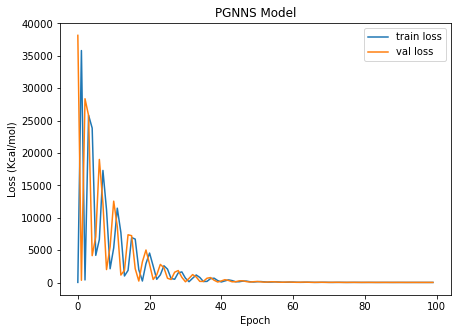

In [24]:
import matplotlib.pyplot as plt
# Calculating the average of k-fold losses
average_PGNNS_train_losses = [sum(x)/len(x) for x in zip(*PGNNS_train_losses)]
average_PGNNS_val_losses = [sum(x)/len(x) for x in zip(*PGNNS_val_losses)]
plt.figure(figsize=(7,5))
plt.plot(range(len(average_PGNNS_train_losses)), average_PGNNS_train_losses, label='train loss')
plt.plot(range(len(average_PGNNS_val_losses)), average_PGNNS_val_losses, label='val loss')
plt.legend(loc='upper right');
plt.xlabel("Epoch")
plt.ylabel("Loss (Kcal/mol)")
# plt.ylim(0,100)
plt.title("PGNNS Model")
# Time stamp with date and time
time.strftime("%Y-%m-%d %H%M%S")

# save plot
plt.savefig("PGNNS_loss" + time.strftime("%Y-%m-%d %H%M%S") + ".png")

# Comparison

In [25]:
from prettytable import PrettyTable
rmse_table = PrettyTable()
rmse_table.title="Models Comparison"
rmse_table.field_names = ["PGNNS (TRAIN)", "PGNNS (TEST)"]
rmse_table.add_row(["{:.2f}".format(average_PGNNS_rmse_train),"{:.2f}".format(average_PGNNS_rmse_test)])

print(rmse_table) 

+------------------------------+
|      Models Comparison       |
+---------------+--------------+
| PGNNS (TRAIN) | PGNNS (TEST) |
+---------------+--------------+
|      3.98     |     4.59     |
+---------------+--------------+


In [26]:
# Variance
PGNNS_train_variance = np.std(PGNNS_rmse_train)
PGNNS_test_variance = np.std(PGNNS_rmse_test)


In [27]:
PGNNS_test_variance

0.1591522769738877

In [28]:
PGNNS_train_variance

0.1688743722765078